In [2]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
import math
from sklearn.metrics import mean_squared_error

In [2]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','O3','PM2_5'])#
one_feature.head(5)
one_feature = one_feature.fillna(0)
# one_feature = one_feature.dropna()

In [3]:
one_feature

,Start,NO2,NOX,PM10
0,2015-01-01 00:00:00,4.5,6.2,28.4
1,2015-01-01 01:00:00,3.1,3.7,8.5
2,2015-01-01 02:00:00,2.1,2.9,8.7
3,2015-01-01 03:00:00,1.6,2.2,10.5
4,2015-01-01 04:00:00,1.4,2.1,12.1
...,...,...,...,...
43819,2019-12-31 19:00:00,4.4,4.6,6.4
43820,2019-12-31 20:00:00,3.2,3.4,4.5
43821,2019-12-31 21:00:00,2.7,2.6,3.0
43822,2019-12-31 22:00:00,3.1,3.1,2.8


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down=one_feature.copy()
scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
scaled_down['NOX']=sc.fit_transform(scaled_down['NOX'].values.reshape(-1, 1))
scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))

In [5]:
train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]

In [6]:
train['predicted_pollution'] = train['PM10'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
train = train.drop(train.tail(1).index)
train=train.drop('Start',axis=1)
train.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,NO2,NOX,PM10,predicted_pollution
0,0.039648,0.009583,0.189614,0.069444
1,0.027313,0.005719,0.069444,0.070652
2,0.018502,0.004482,0.070652,0.081522
3,0.014097,0.003400,0.081522,0.091184
4,0.012335,0.003246,0.091184,0.094807


In [7]:
test['predicted_pollution'] = test['PM10'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
test = test.drop(test.tail(1).index)
test=test.drop('Start',axis=1)

test.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,NO2,NOX,PM10,predicted_pollution
35064,0.041410,0.008501,0.243357,0.102053
35065,0.038767,0.007883,0.102053,0.051329
35066,0.030837,0.006337,0.051329,0.039855
35067,0.014097,0.003246,0.039855,0.052536
35068,0.021145,0.004946,0.052536,0.044082


In [8]:
train_values=train.values
test_values=test.values
test_X, test_y = test_values[:, :-1], test_values[:, -1]
train_X, train_y = train_values[:, :-1], train_values[:, -1]

In [9]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Epoch 1/50
487/487 - 1s - loss: 0.0021 - val_loss: 0.0017
Epoch 2/50
487/487 - 1s - loss: 0.0011 - val_loss: 9.0218e-04
Epoch 3/50
487/487 - 1s - loss: 8.7099e-04 - val_loss: 8.7812e-04
Epoch 4/50
487/487 - 1s - loss: 8.6359e-04 - val_loss: 8.9328e-04
Epoch 5/50
487/487 - 1s - loss: 8.6083e-04 - val_loss: 8.9452e-04
Epoch 6/50
487/487 - 1s - loss: 8.5824e-04 - val_loss: 8.8887e-04
Epoch 7/50
487/487 - 1s - loss: 8.5537e-04 - val_loss: 8.8298e-04
Epoch 8/50
487/487 - 1s - loss: 8.5225e-04 - val_loss: 8.7878e-04
Epoch 9/50
487/487 - 1s - loss: 8.4904e-04 - val_loss: 8.7615e-04
Epoch 10/50
487/487 - 1s - loss: 8.4589e-04 - val_loss: 8.7460e-04
Epoch 11/50
487/487 - 1s - loss: 8.4289e-04 - val_loss: 8.7374e-04
Epoch 12/50
487/487 - 1s - loss: 8.4009e-04 - val_loss: 8.7332e-04
Epoch 13/50
487/487 - 1s - loss: 8.3751e-04 - val_loss: 8.7321e-04
Epoch 14/50
487/487 - 1s - loss: 8.3516e-04 - val_loss: 8.7333e-04
Epoch 15/50
487/487 - 1s - loss: 8.3303e-04 - val_loss: 8.7364e-04
Epoch 16/50
487/

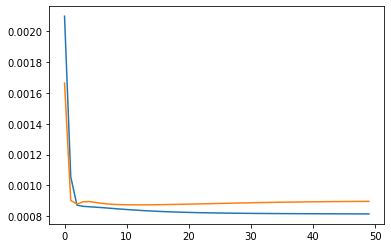

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')#orange is validation loss

In [12]:
# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
yhat = model.predict(test_X)


inv_yhat = sc.inverse_transform(yhat)



inv_y = sc.inverse_transform(test_y.reshape(-1, 1))


# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

'3.397'

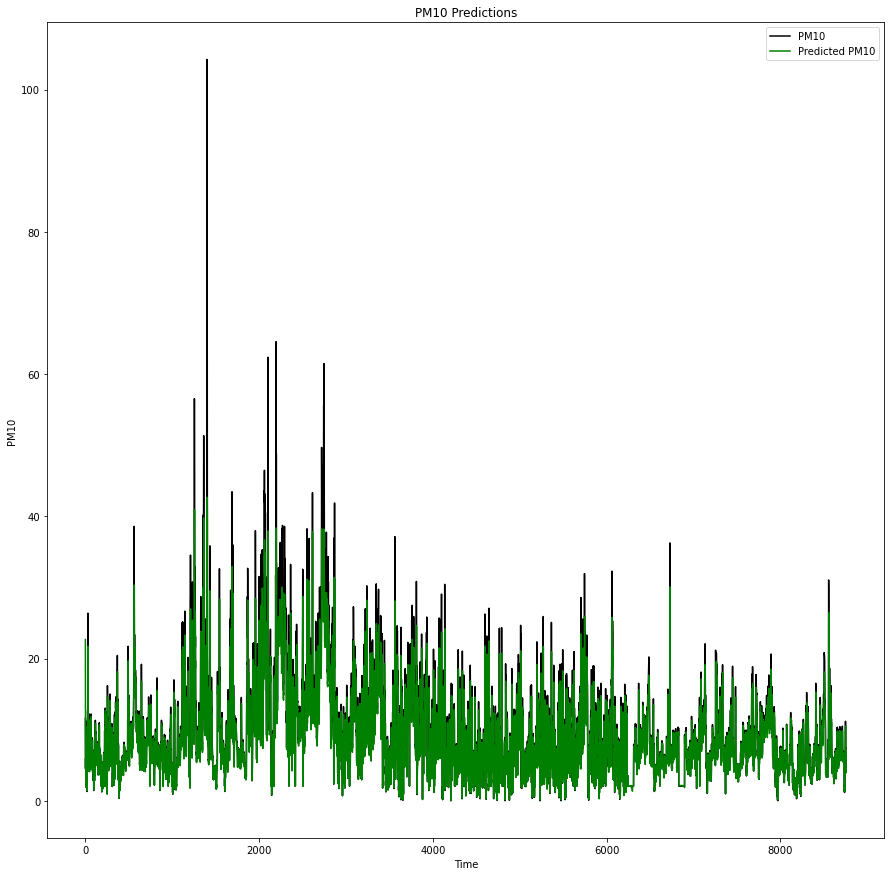

In [13]:

fig = plt.figure(figsize=(15,15))
plt.plot(inv_y, color = 'black', label = 'PM10')
plt.plot(inv_yhat, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()


In [14]:
train_X.shape

(35063, 1, 3)

# Test 2


In [124]:
dataPath = 'Data/2016-2019(NO2, NOX, PM2.5)'
listOfDataFrames=[]
stations=os.listdir(dataPath)
for station in stations:
    print("Processing year: "+ dataPath +" station: "+station)
    airQualityData=pd.read_csv(dataPath+'\\'+station, header=12,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    listOfDataFrames.append(airQualityData)
airQualityData= pd.DataFrame(columns= [])
for airData in listOfDataFrames:
    airQualityData=airQualityData.append(airData)
    
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
print(airQualityData.head(5))
print(airQualityData.shape)

Processing year: Data/2016-2019(NO2, NOX, PM2.5) station: shair-8779-1-6-3.csv
                Start              Stop   NO2   NOX  PM10  PM2_5
0 2016-01-01 00:00:00  2016-01-01 01:00  31.8  47.1  36.3   27.0
1 2016-01-01 01:00:00  2016-01-01 02:00  32.3  48.3  15.8    9.0
2 2016-01-01 02:00:00  2016-01-01 03:00  25.9  36.2  14.4    8.5
3 2016-01-01 03:00:00  2016-01-01 04:00  36.1  55.6  13.9    6.0
4 2016-01-01 04:00:00  2016-01-01 05:00  30.2  47.7  16.0    7.0
(35064, 6)


In [125]:

airQualityData= airQualityData.fillna(0)

In [126]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down=airQualityData.copy()
scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
scaled_down['NOX']=sc.fit_transform(scaled_down['NOX'].values.reshape(-1, 1))
scaled_down['PM2_5']=sc.fit_transform(scaled_down['PM2_5'].values.reshape(-1, 1))
scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))

In [127]:
train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]

In [128]:
train['predicted_NO2'] = train['NO2'].shift(-1)
train['predicted_NOX'] = train['NOX'].shift(-1)
train['predicted_PM10'] = train['PM10'].shift(-1)
train['predicted_PM2_5'] = train['PM2_5'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
train = train.drop(train.tail(1).index)
train=train.drop('Start',axis=1)
train=train.drop('Stop',axis=1)

train.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,NO2,NOX,PM10,PM2_5,predicted_NO2,predicted_NOX,predicted_PM10,predicted_PM2_5
0,0.149436,0.047939,0.119731,0.277778,0.151786,0.049160,0.057117,0.111111
1,0.151786,0.049160,0.057117,0.111111,0.121711,0.036845,0.052841,0.106481
2,0.121711,0.036845,0.052841,0.106481,0.169643,0.056590,0.051313,0.083333
3,0.169643,0.056590,0.051313,0.083333,0.141917,0.048550,0.057728,0.092593
4,0.141917,0.048550,0.057728,0.092593,0.137688,0.044173,0.058644,0.093519


In [129]:
test['predicted_NO2'] = test['NO2'].shift(-1)
test['predicted_NOX'] = test['NOX'].shift(-1)
test['predicted_PM10'] = test['PM10'].shift(-1)
test['predicted_PM2_5'] = test['PM2_5'].shift(-1)
# Drop the last row (it has no value for predicted pollution)
test = test.drop(test.tail(1).index)
test=test.drop('Start',axis=1)
test=test.drop('Stop',axis=1)
test.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,NO2,NOX,PM10,PM2_5,predicted_NO2,predicted_NOX,predicted_PM10,predicted_PM2_5
26304,0.072368,0.029924,0.105376,0.301852,0.000000,0.000000,0.060476,0.112963
26305,0.000000,0.000000,0.060476,0.112963,0.062030,0.022087,0.037874,0.046296
26306,0.062030,0.022087,0.037874,0.046296,0.081297,0.033181,0.033903,0.043519
26307,0.081297,0.033181,0.033903,0.043519,0.051222,0.020560,0.041234,0.029630
26308,0.051222,0.020560,0.041234,0.029630,0.064850,0.029109,0.037569,0.046296


In [130]:
train_values=train.values
test_values=test.values
test_X, test_y = test_values[:, 0:4], test_values[:, 4:8]
train_X, train_y = train_values[:, 0:4], train_values[:, 4:8]

In [131]:
train_X

array([[0.14943609, 0.04793893, 0.11973122, 0.27777778],
       [0.15178571, 0.04916031, 0.05711668, 0.11111111],
       [0.12171053, 0.03684478, 0.05284056, 0.10648148],
       ...,
       [0.0662594 , 0.02768448, 0.03848503, 0.10740741],
       [0.06203008, 0.02340967, 0.04031765, 0.08055556],
       [0.08740602, 0.03226463, 0.03543067, 0.07777778]])

In [132]:
train_y

array([[0.15178571, 0.04916031, 0.05711668, 0.11111111],
       [0.12171053, 0.03684478, 0.05284056, 0.10648148],
       [0.16964286, 0.05659033, 0.05131338, 0.08333333],
       ...,
       [0.06203008, 0.02340967, 0.04031765, 0.08055556],
       [0.08740602, 0.03226463, 0.03543067, 0.07777778],
       [0.09680451, 0.0421374 , 0.04551008, 0.10555556]])

In [133]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((26303, 1, 4), (26303, 4), (8759, 1, 4), (8759, 4))

In [134]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam')

history = model.fit(train_X, train_y, epochs=30,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Epoch 1/30
366/366 - 1s - loss: 0.0049 - val_loss: 0.0033
Epoch 2/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 3/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 4/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 5/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 6/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 7/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 8/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 9/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 10/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 11/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 12/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 13/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 14/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 15/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 16/30
366/366 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 17/30
366/366 - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 

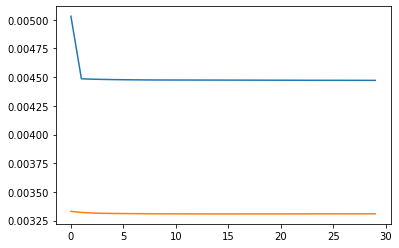

In [122]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')#orange is validation loss

In [123]:
# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
yhat = model.predict(test_X)


inv_yhat = sc.inverse_transform(yhat)



inv_y = sc.inverse_transform(test_y.reshape(-1, 1))


# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

ValueError: Found input variables with inconsistent numbers of samples: [35040, 8760]

In [ ]:
inv_yhat.shape

In [ ]:
test_y.shape

In [ ]:
test_X.shape

In [ ]:
train_X.shape[2]

In [ ]:
inv_yhat

In [ ]:
test_y

In [ ]:
train_X.shape[1]